<a href="https://colab.research.google.com/github/gabriel-arrvda/parking-detection-api/blob/main/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
import ultralytics
from ultralytics import YOLO
from google.colab import files
import os
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d trainingdatapro/parking-space-detection-dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/trainingdatapro/parking-space-detection-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
parking-space-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
import zipfile
with zipfile.ZipFile('parking-space-detection-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('./dataset')

In [11]:
import os
import xml.etree.ElementTree as ET

# Input paths
XML_FILE = "dataset/annotations.xml"  # Update with your actual XML path
OUTPUT_DIR = "dataset/labels"
IMAGE_DIR = "dataset/images"  # Directory where images are stored

# Class mapping
CLASS_NAMES = {
    "free_parking_space": 0,
    "not_free_parking_space": 1,
    "partially_free_parking_space": 2
}

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

def convert_polygon_to_yolo_bbox(polygon_points, img_width, img_height):
    """ Convert polygon points to YOLO (x_center, y_center, width, height) format """
    x_coords = [float(p.split(",")[0]) for p in polygon_points]
    y_coords = [float(p.split(",")[1]) for p in polygon_points]

    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height

    return (x_center, y_center, width, height)

def parse_cvat_xml(xml_file):
    """ Parse CVAT XML and convert to YOLO format """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    for image in root.findall("image"):
        img_name = image.get("name")
        img_width = int(image.get("width"))
        img_height = int(image.get("height"))

        label_file = os.path.join(OUTPUT_DIR, os.path.basename(img_name).replace(".png", ".txt"))

        with open(label_file, "w") as f:
            for polygon in image.findall("polygon"):
                label = polygon.get("label")
                if label not in CLASS_NAMES:
                    continue  # Skip unknown labels

                class_id = CLASS_NAMES[label]
                points = polygon.get("points").split(";")
                yolo_bbox = convert_polygon_to_yolo_bbox(points, img_width, img_height)

                f.write(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")

        print(f"✅ Converted: {img_name} -> {label_file}")

# Run conversion
parse_cvat_xml(XML_FILE)
print("🚀 Conversion complete! YOLO labels saved in:", OUTPUT_DIR)


✅ Converted: images/0.png -> dataset/labels/0.txt
✅ Converted: images/1.png -> dataset/labels/1.txt
✅ Converted: images/10.png -> dataset/labels/10.txt
✅ Converted: images/11.png -> dataset/labels/11.txt
✅ Converted: images/12.png -> dataset/labels/12.txt
✅ Converted: images/13.png -> dataset/labels/13.txt
✅ Converted: images/14.png -> dataset/labels/14.txt
✅ Converted: images/15.png -> dataset/labels/15.txt
✅ Converted: images/17.png -> dataset/labels/17.txt
✅ Converted: images/18.png -> dataset/labels/18.txt
✅ Converted: images/19.png -> dataset/labels/19.txt
✅ Converted: images/2.png -> dataset/labels/2.txt
✅ Converted: images/20.png -> dataset/labels/20.txt
✅ Converted: images/21.png -> dataset/labels/21.txt
✅ Converted: images/22.png -> dataset/labels/22.txt
✅ Converted: images/24.png -> dataset/labels/24.txt
✅ Converted: images/25.png -> dataset/labels/25.txt
✅ Converted: images/26.png -> dataset/labels/26.txt
✅ Converted: images/27.png -> dataset/labels/27.txt
✅ Converted: image

In [12]:
!pip install split-folders

In [13]:
import splitfolders

# Define the input and output directories
input_dir = "dataset"  # Path to your dataset
output_dir = "split_dataset"  # Path to save the split dataset

# Split the dataset (e.g., 80% train, 20% validation)
splitfolders.ratio(
    input_dir,
    output=output_dir,
    seed=42,  # Random seed for reproducibility
    ratio=(0.8, 0.2),  # Train/validation split ratio
    group_prefix=None,  # Preserve folder structure
    move=False,  # Copy files instead of moving them
)

print("Dataset split completed!")

Copying files: 120 files [00:00, 1023.98 files/s]

Dataset split completed!


In [61]:
from PIL import Image
from IPython.display import display

def plot_images(image_paths):
  # Open images
  images = [Image.open(img_path) for img_path in image_paths]

  # Resize images to a fixed size (optional)
  resized_images = [img.resize((600, 200)) for img in images]

  # Define grid parameters
  images_per_row = 2  # Number of images per row
  image_width = resized_images[0].width  # Width of each image
  image_height = resized_images[0].height  # Height of each image

  # Calculate grid size
  num_images = len(resized_images)
  num_rows = (num_images + images_per_row - 1) // images_per_row  # Number of rows needed
  grid_width = images_per_row * image_width  # Total width of the grid
  grid_height = num_rows * image_height  # Total height of the grid

  # Create a new image to hold the grid
  grid_image = Image.new("RGB", (grid_width, grid_height))

  # Paste images into the grid
  for idx, img in enumerate(resized_images):
      x_offset = (idx % images_per_row) * image_width  # Calculate x position
      y_offset = (idx // images_per_row) * image_height  # Calculate y position
      grid_image.paste(img, (x_offset, y_offset))

  # Display the grid
  display(grid_image)

In [78]:
# Load a model
model = YOLO("yolov8n.pt")     # load a pretrained model (recommended for training)

# Use the model
metrics = model.train(
    data="parking.yaml",
    epochs=1000,
    pretrained=True,
    iou=0.6,
    visualize=True,
    patience=15,  # Early stopping
    augment=True,  # Aumento de dados
    weight_decay=0.0010,  # Regularização L2
    dropout=0.25,  # Dropout
    lr0=0.0005,  # Taxa de aprendizado reduzida
    batch=2  # Tamanho do batch ajustado
)# train the model

100%|██████████| 6.25M/6.25M [00:00<00:00, 314MB/s]

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=parking.yaml, epochs=1000, time=None, patience=15, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.25, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.6, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=True, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

Model summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train13', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /content/split_dataset/train/labels.cache... 24 images, 0 backgrounds, 0 corrupt: 100%|██████████| 24/24 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/split_dataset/val/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<?, ?it/s]


Plotting labels to runs/detect/train13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train13
Starting training for 1000 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     1/1000     0.537G      2.045       3.76      1.725         88        640: 100%|██████████| 12/12 [00:01<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.24it/s]

                   all          6        154     0.0734      0.373      0.076     0.0306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     2/1000      0.51G       1.75      3.692      1.465        141        640: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.25it/s]

                   all          6        154     0.0736      0.416      0.105     0.0497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     3/1000     0.492G      1.555      3.335      1.357         67        640: 100%|██████████| 12/12 [00:01<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.01it/s]

                   all          6        154     0.0773      0.468        0.2     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     4/1000      0.42G      1.351      3.008      1.231         39        640: 100%|██████████| 12/12 [00:01<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.82it/s]

                   all          6        154     0.0859       0.61      0.322      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     5/1000      0.41G      1.361      2.742      1.213        102        640: 100%|██████████| 12/12 [00:01<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.76it/s]

                   all          6        154      0.883      0.225      0.413      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     6/1000     0.447G      1.393      2.658      1.235         73        640: 100%|██████████| 12/12 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.82it/s]

                   all          6        154      0.883      0.225      0.413      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     7/1000     0.439G      1.308      2.538      1.176         90        640: 100%|██████████| 12/12 [00:01<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.49it/s]

                   all          6        154      0.401      0.436      0.473      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     8/1000     0.438G      1.302      2.482      1.193         85        640: 100%|██████████| 12/12 [00:01<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.18it/s]

                   all          6        154      0.401      0.436      0.473      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     9/1000     0.441G      1.278      2.358      1.171        146        640: 100%|██████████| 12/12 [00:01<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.19it/s]

                   all          6        154      0.401      0.436      0.473      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    10/1000     0.498G      1.304      2.257      1.196        194        640: 100%|██████████| 12/12 [00:01<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]

                   all          6        154      0.406      0.405      0.456       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    11/1000     0.523G      1.335      2.299      1.237         66        640: 100%|██████████| 12/12 [00:01<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.04it/s]

                   all          6        154      0.406      0.405      0.456       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    12/1000     0.434G      1.253      2.285      1.206         64        640: 100%|██████████| 12/12 [00:01<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.15it/s]

                   all          6        154      0.518      0.391        0.5      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    13/1000     0.449G        1.2      1.928      1.169         58        640: 100%|██████████| 12/12 [00:01<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.25it/s]

                   all          6        154      0.518      0.391        0.5      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    14/1000     0.506G      1.267      2.113      1.164        192        640: 100%|██████████| 12/12 [00:01<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.31it/s]

                   all          6        154      0.518      0.391        0.5      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    15/1000     0.443G      1.262      2.129      1.187         86        640: 100%|██████████| 12/12 [00:01<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.06it/s]

                   all          6        154      0.671      0.396      0.527      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    16/1000     0.447G      1.101      1.996      1.101        171        640: 100%|██████████| 12/12 [00:01<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.87it/s]

                   all          6        154      0.671      0.396      0.527      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    17/1000     0.412G      1.106      1.993      1.133         69        640: 100%|██████████| 12/12 [00:01<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.99it/s]

                   all          6        154      0.671      0.396      0.527      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    18/1000     0.424G      1.317      1.951      1.171        234        640: 100%|██████████| 12/12 [00:01<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.88it/s]

                   all          6        154      0.307      0.727      0.518      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    19/1000     0.494G      1.151      1.758      1.152        254        640: 100%|██████████| 12/12 [00:01<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.11it/s]

                   all          6        154      0.307      0.727      0.518      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    20/1000     0.486G      1.172      1.949      1.135        187        640: 100%|██████████| 12/12 [00:01<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.76it/s]

                   all          6        154      0.412      0.728      0.552      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    21/1000     0.418G      1.069      1.668       1.14         92        640: 100%|██████████| 12/12 [00:01<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.92it/s]

                   all          6        154      0.412      0.728      0.552      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    22/1000     0.449G      1.135      1.665      1.128        114        640: 100%|██████████| 12/12 [00:01<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.06it/s]

                   all          6        154      0.412      0.728      0.552      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    23/1000     0.465G      1.136      1.563      1.192         59        640: 100%|██████████| 12/12 [00:01<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]


                   all          6        154      0.475      0.712      0.578      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    24/1000     0.488G      1.104      1.591      1.144         75        640: 100%|██████████| 12/12 [00:01<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.41it/s]

                   all          6        154      0.475      0.712      0.578      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    25/1000     0.441G     0.9894      1.529      1.096         76        640: 100%|██████████| 12/12 [00:01<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.41it/s]

                   all          6        154      0.475      0.712      0.578      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    26/1000     0.441G      1.123      1.475      1.118        152        640: 100%|██████████| 12/12 [00:01<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.36it/s]

                   all          6        154      0.547      0.663      0.606      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    27/1000     0.443G      1.065      1.516      1.114         85        640: 100%|██████████| 12/12 [00:01<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.69it/s]

                   all          6        154      0.547      0.663      0.606      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    28/1000     0.445G     0.9327      1.413      1.048        155        640: 100%|██████████| 12/12 [00:01<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.79it/s]

                   all          6        154      0.516      0.834      0.653      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    29/1000     0.475G     0.9518      1.386      1.053         60        640: 100%|██████████| 12/12 [00:01<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]

                   all          6        154      0.516      0.834      0.653      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    30/1000     0.416G      1.083      1.482      1.143         78        640: 100%|██████████| 12/12 [00:01<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 13.13it/s]

                   all          6        154      0.516      0.834      0.653      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    31/1000     0.473G      1.012      1.386      1.107        160        640: 100%|██████████| 12/12 [00:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.44it/s]

                   all          6        154       0.59      0.726      0.751      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    32/1000     0.461G      0.946      1.262      1.063         52        640: 100%|██████████| 12/12 [00:01<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.89it/s]

                   all          6        154       0.59      0.726      0.751      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    33/1000     0.412G     0.9733      1.205      1.086         69        640: 100%|██████████| 12/12 [00:01<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.47it/s]

                   all          6        154       0.59      0.726      0.751      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    34/1000     0.424G     0.9732      1.229      1.111         89        640: 100%|██████████| 12/12 [00:01<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.83it/s]

                   all          6        154      0.797      0.721      0.827      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    35/1000     0.439G     0.9671      1.217      1.071        107        640: 100%|██████████| 12/12 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.13it/s]

                   all          6        154      0.797      0.721      0.827      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    36/1000     0.445G     0.9163      1.205      1.083        200        640: 100%|██████████| 12/12 [00:01<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]

                   all          6        154      0.799      0.777      0.847      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    37/1000     0.445G     0.8742      1.157      1.041        110        640: 100%|██████████| 12/12 [00:01<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.14it/s]

                   all          6        154      0.799      0.777      0.847      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    38/1000       0.4G      0.957      1.221      1.129         97        640: 100%|██████████| 12/12 [00:01<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.41it/s]

                   all          6        154      0.799      0.777      0.847      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    39/1000     0.434G      0.934      1.078      1.059         86        640: 100%|██████████| 12/12 [00:01<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.81it/s]

                   all          6        154      0.796      0.776      0.871      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    40/1000     0.422G     0.9046      1.134      1.088        100        640: 100%|██████████| 12/12 [00:01<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.50it/s]

                   all          6        154      0.796      0.776      0.871      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    41/1000     0.477G     0.9122      1.071      1.059         75        640: 100%|██████████| 12/12 [00:01<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.32it/s]

                   all          6        154      0.796      0.776      0.871      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    42/1000     0.461G     0.9189      1.175       1.08        102        640: 100%|██████████| 12/12 [00:01<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.66it/s]

                   all          6        154      0.869      0.735      0.861       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    43/1000     0.438G     0.9428      1.023      1.068        103        640: 100%|██████████| 12/12 [00:01<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.98it/s]

                   all          6        154      0.869      0.735      0.861       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    44/1000     0.443G      0.867      1.107      1.062         74        640: 100%|██████████| 12/12 [00:01<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.87it/s]

                   all          6        154      0.825      0.815      0.883      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    45/1000     0.492G     0.8692      1.011      1.042        118        640: 100%|██████████| 12/12 [00:01<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.90it/s]

                   all          6        154      0.825      0.815      0.883      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    46/1000     0.414G     0.8384     0.9693      1.026        121        640: 100%|██████████| 12/12 [00:01<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 19.31it/s]

                   all          6        154      0.825      0.815      0.883      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    47/1000     0.416G     0.8864     0.9406      1.056        138        640: 100%|██████████| 12/12 [00:01<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.83it/s]

                   all          6        154      0.933      0.795      0.903      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    48/1000     0.457G     0.8835       1.01      1.022        191        640: 100%|██████████| 12/12 [00:01<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.01it/s]

                   all          6        154      0.933      0.795      0.903      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    49/1000     0.445G     0.8868     0.9851      1.045        145        640: 100%|██████████| 12/12 [00:01<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.07it/s]

                   all          6        154      0.933      0.795      0.903      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    50/1000     0.451G     0.7558     0.9431     0.9978        187        640: 100%|██████████| 12/12 [00:01<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.47it/s]

                   all          6        154       0.86      0.833       0.92      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    51/1000     0.426G     0.7885     0.9466     0.9751        170        640: 100%|██████████| 12/12 [00:01<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.60it/s]

                   all          6        154       0.86      0.833       0.92      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    52/1000     0.449G     0.7936     0.9295     0.9948         61        640: 100%|██████████| 12/12 [00:01<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.98it/s]

                   all          6        154      0.897      0.851      0.932      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    53/1000     0.445G     0.7441     0.9375      1.008         62        640: 100%|██████████| 12/12 [00:01<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.54it/s]

                   all          6        154      0.897      0.851      0.932      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    54/1000      0.43G     0.7885      0.873     0.9777         86        640: 100%|██████████| 12/12 [00:01<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.34it/s]

                   all          6        154      0.897      0.851      0.932      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    55/1000     0.414G     0.7576      0.941     0.9998        129        640: 100%|██████████| 12/12 [00:01<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.81it/s]

                   all          6        154      0.966       0.83      0.926      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    56/1000     0.436G     0.7825     0.9206      1.017         80        640: 100%|██████████| 12/12 [00:01<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 14.41it/s]

                   all          6        154      0.966       0.83      0.926      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    57/1000     0.443G     0.7787     0.9083     0.9938        182        640: 100%|██████████| 12/12 [00:01<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.44it/s]

                   all          6        154      0.966       0.83      0.926      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    58/1000     0.451G     0.7359     0.9073     0.9721        108        640: 100%|██████████| 12/12 [00:01<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.65it/s]

                   all          6        154      0.978      0.854      0.936      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    59/1000     0.439G     0.7618     0.8982      1.015        197        640: 100%|██████████| 12/12 [00:01<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.97it/s]

                   all          6        154      0.978      0.854      0.936      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    60/1000     0.414G     0.7833     0.8639          1        152        640: 100%|██████████| 12/12 [00:01<00:00, 10.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.84it/s]

                   all          6        154      0.956      0.868      0.941      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    61/1000      0.43G     0.7235     0.8455     0.9873        111        640: 100%|██████████| 12/12 [00:01<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]

                   all          6        154      0.956      0.868      0.941      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    62/1000     0.436G     0.7313     0.8574      0.987        104        640: 100%|██████████| 12/12 [00:01<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.94it/s]

                   all          6        154      0.956      0.868      0.941      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    63/1000     0.439G     0.7118     0.8177     0.9768        124        640: 100%|██████████| 12/12 [00:01<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.95it/s]

                   all          6        154      0.935      0.893      0.959      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    64/1000     0.436G     0.7803     0.8441      1.016        178        640: 100%|██████████| 12/12 [00:01<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.51it/s]

                   all          6        154      0.935      0.893      0.959      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    65/1000      0.48G     0.7437     0.8429     0.9643        109        640: 100%|██████████| 12/12 [00:01<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]

                   all          6        154      0.935      0.893      0.959      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    66/1000     0.445G     0.6857     0.8088     0.9608        104        640: 100%|██████████| 12/12 [00:01<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.68it/s]

                   all          6        154      0.928      0.901      0.958      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    67/1000     0.416G     0.6984     0.7857     0.9616        121        640: 100%|██████████| 12/12 [00:01<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.18it/s]


                   all          6        154      0.928      0.901      0.958      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    68/1000     0.461G     0.7576     0.8641     0.9477         82        640: 100%|██████████| 12/12 [00:01<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.74it/s]

                   all          6        154      0.957      0.868      0.956      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    69/1000      0.42G     0.7259     0.7795     0.9442        107        640: 100%|██████████| 12/12 [00:01<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.88it/s]

                   all          6        154      0.957      0.868      0.956      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    70/1000     0.447G     0.6483     0.8135     0.9442         65        640: 100%|██████████| 12/12 [00:01<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.54it/s]

                   all          6        154      0.957      0.868      0.956      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    71/1000     0.498G     0.7531     0.8614     0.9583        137        640: 100%|██████████| 12/12 [00:01<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.96it/s]

                   all          6        154      0.961      0.861      0.959      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    72/1000      0.48G     0.7275      0.815     0.9565        179        640: 100%|██████████| 12/12 [00:01<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.40it/s]

                   all          6        154      0.961      0.861      0.959      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    73/1000     0.443G      0.719     0.7964     0.9438        117        640: 100%|██████████| 12/12 [00:01<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


                   all          6        154      0.961      0.861      0.959      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    74/1000     0.457G     0.7306     0.8441     0.9581         87        640: 100%|██████████| 12/12 [00:01<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.02it/s]

                   all          6        154      0.957      0.895      0.967      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    75/1000     0.432G     0.6264     0.8086     0.9352         52        640: 100%|██████████| 12/12 [00:01<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.80it/s]

                   all          6        154      0.957      0.895      0.967      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    76/1000     0.479G     0.7221     0.7858     0.9312        166        640: 100%|██████████| 12/12 [00:01<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.94it/s]

                   all          6        154      0.959      0.891      0.969      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    77/1000     0.438G     0.6863     0.7723     0.9578         56        640: 100%|██████████| 12/12 [00:01<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.82it/s]

                   all          6        154      0.959      0.891      0.969      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    78/1000     0.438G     0.7234     0.7865     0.9662         72        640: 100%|██████████| 12/12 [00:01<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.09it/s]

                   all          6        154      0.959      0.891      0.969      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    79/1000     0.471G     0.7098     0.7895     0.9565         45        640: 100%|██████████| 12/12 [00:01<00:00,  9.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.06it/s]

                   all          6        154      0.958        0.9      0.964      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    80/1000     0.436G     0.6939     0.7693     0.9562         78        640: 100%|██████████| 12/12 [00:01<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.98it/s]

                   all          6        154      0.958        0.9      0.964      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    81/1000     0.436G     0.6322     0.7556     0.9352         70        640: 100%|██████████| 12/12 [00:01<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.35it/s]

                   all          6        154      0.958        0.9      0.964      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    82/1000     0.443G     0.6686     0.7863     0.9434        117        640: 100%|██████████| 12/12 [00:01<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.88it/s]

                   all          6        154      0.968      0.868      0.953      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    83/1000      0.41G     0.6959     0.7838     0.9629        114        640: 100%|██████████| 12/12 [00:01<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.76it/s]

                   all          6        154      0.968      0.868      0.953      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    84/1000     0.477G     0.6824      0.784     0.9653         92        640: 100%|██████████| 12/12 [00:01<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.87it/s]

                   all          6        154      0.964      0.891      0.958      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    85/1000      0.43G     0.7133     0.7847     0.9554         66        640: 100%|██████████| 12/12 [00:01<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.64it/s]


                   all          6        154      0.964      0.891      0.958      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    86/1000     0.438G     0.6471     0.7462     0.9406        166        640: 100%|██████████| 12/12 [00:01<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.14it/s]

                   all          6        154      0.964      0.891      0.958      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    87/1000     0.457G     0.7437      0.796     0.9615        113        640: 100%|██████████| 12/12 [00:01<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.22it/s]

                   all          6        154      0.986       0.87      0.968      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    88/1000     0.498G     0.7012     0.7431     0.9578        107        640: 100%|██████████| 12/12 [00:01<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.02it/s]

                   all          6        154      0.986       0.87      0.968      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    89/1000     0.523G     0.6835     0.7852     0.9798        107        640: 100%|██████████| 12/12 [00:01<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.18it/s]

                   all          6        154      0.986       0.87      0.968      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    90/1000     0.439G      0.607     0.7474     0.9306         64        640: 100%|██████████| 12/12 [00:01<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.36it/s]

                   all          6        154       0.98      0.868      0.965      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    91/1000     0.416G     0.6781     0.7627     0.9519         89        640: 100%|██████████| 12/12 [00:01<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.97it/s]

                   all          6        154       0.98      0.868      0.965      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    92/1000     0.428G     0.6162     0.7367     0.9316         78        640: 100%|██████████| 12/12 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.55it/s]

                   all          6        154      0.971       0.88      0.965      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    93/1000     0.443G     0.6948     0.7422     0.9428        100        640: 100%|██████████| 12/12 [00:01<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.06it/s]

                   all          6        154      0.971       0.88      0.965      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    94/1000     0.439G     0.6591     0.7546     0.9455         93        640: 100%|██████████| 12/12 [00:01<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.04it/s]

                   all          6        154      0.971       0.88      0.965      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    95/1000     0.412G     0.6033     0.6824     0.8882         69        640: 100%|██████████| 12/12 [00:01<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.50it/s]

                   all          6        154      0.947      0.888      0.968      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    96/1000     0.443G     0.6057     0.7143     0.9248         75        640: 100%|██████████| 12/12 [00:01<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.20it/s]

                   all          6        154      0.947      0.888      0.968      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    97/1000      0.48G     0.7326     0.7672     0.9491         85        640: 100%|██████████| 12/12 [00:01<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 18.46it/s]

                   all          6        154      0.947      0.888      0.968      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    98/1000     0.414G     0.6705     0.7309      0.945        130        640: 100%|██████████| 12/12 [00:01<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]

                   all          6        154      0.948      0.898      0.975       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    99/1000     0.414G     0.6432     0.7178     0.9306        134        640: 100%|██████████| 12/12 [00:01<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.68it/s]

                   all          6        154      0.948      0.898      0.975       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   100/1000      0.49G     0.6679     0.7247     0.9055        119        640: 100%|██████████| 12/12 [00:01<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 17.29it/s]

                   all          6        154       0.97      0.878      0.975      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   101/1000     0.441G      0.654     0.6989     0.9176         86        640: 100%|██████████| 12/12 [00:01<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 16.94it/s]

                   all          6        154       0.97      0.878      0.975      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


   102/1000     0.451G     0.7058     0.7427     0.9396        100        640: 100%|██████████| 12/12 [00:01<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 15.95it/s]

                   all          6        154       0.97      0.878      0.975      0.848
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 87, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



102 epochs completed in 0.059 hours.
Optimizer stripped from runs/detect/train13/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train13/weights/best.pt, 6.3MB

Validating runs/detect/train13/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


                   all          6        154      0.943      0.901      0.957      0.844
    free_parking_space          6         45      0.926      0.839      0.929      0.833
not_free_parking_space          6        109      0.959      0.963      0.985      0.855
Speed: 0.3ms preprocess, 114.2ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train13


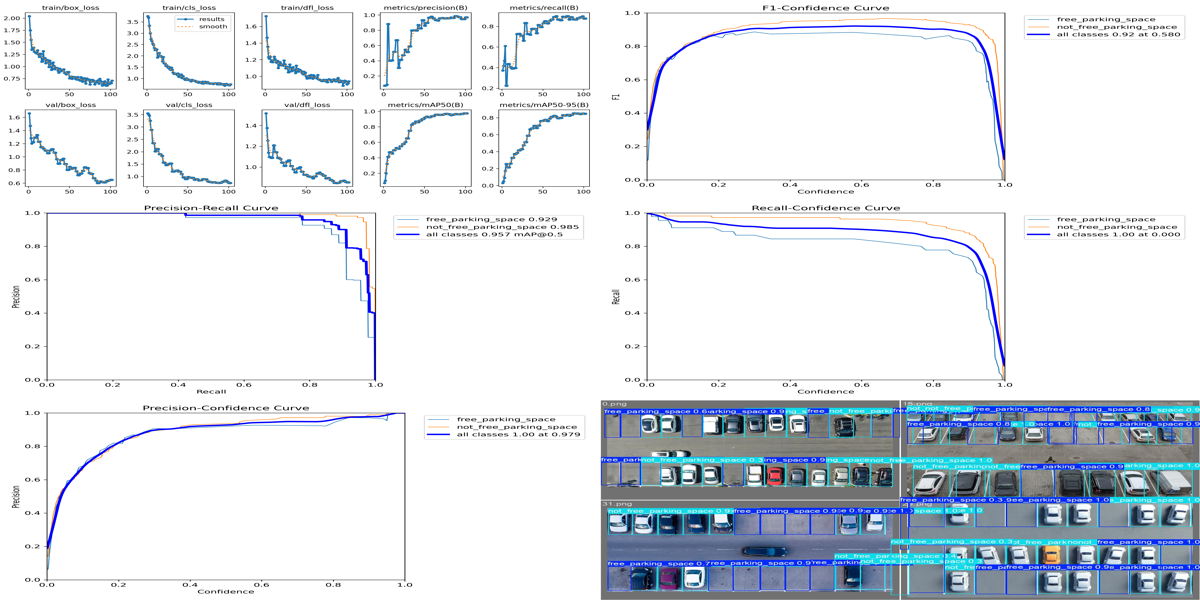

In [79]:
# List of image paths
image_paths = [
    f"{metrics.save_dir}/results.png",
    f"{metrics.save_dir}/F1_curve.png",
    f"{metrics.save_dir}/PR_curve.png",
    f"{metrics.save_dir}/R_curve.png",
    f"{metrics.save_dir}/P_curve.png",
    f"{metrics.save_dir}/val_batch0_pred.jpg",
]

plot_images(image_paths)

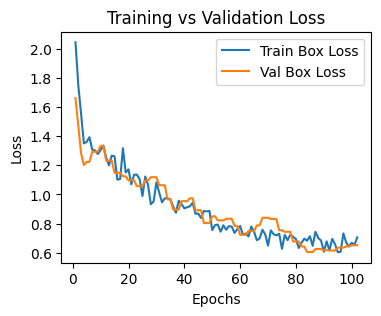

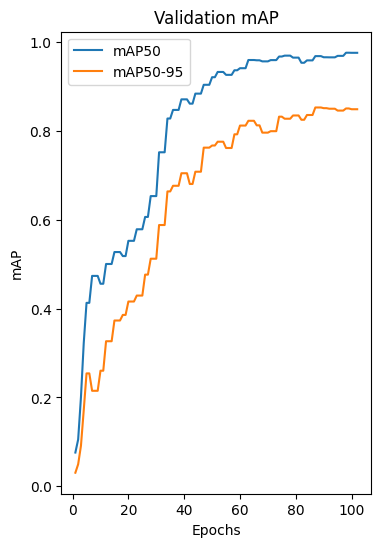

In [80]:
import matplotlib.pyplot as plt
import pandas as pd

# Carregar o CSV
df = pd.read_csv(f"{metrics.save_dir}/results.csv")

# Plotar as curvas de loss
plt.figure(figsize=(4, 3))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Plotar as métricas de validação
plt.figure(figsize=(4, 6))
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP50")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP50-95")
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("Validation mAP")
plt.legend()
plt.show()

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/split_dataset/val/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


                   all          6        154      0.948      0.902      0.962      0.851
    free_parking_space          6         45      0.923      0.844      0.937      0.845
not_free_parking_space          6        109      0.972      0.959      0.986      0.857
Speed: 0.9ms preprocess, 256.8ms inference, 0.0ms loss, 8.3ms postprocess per image
Results saved to runs/detect/train132


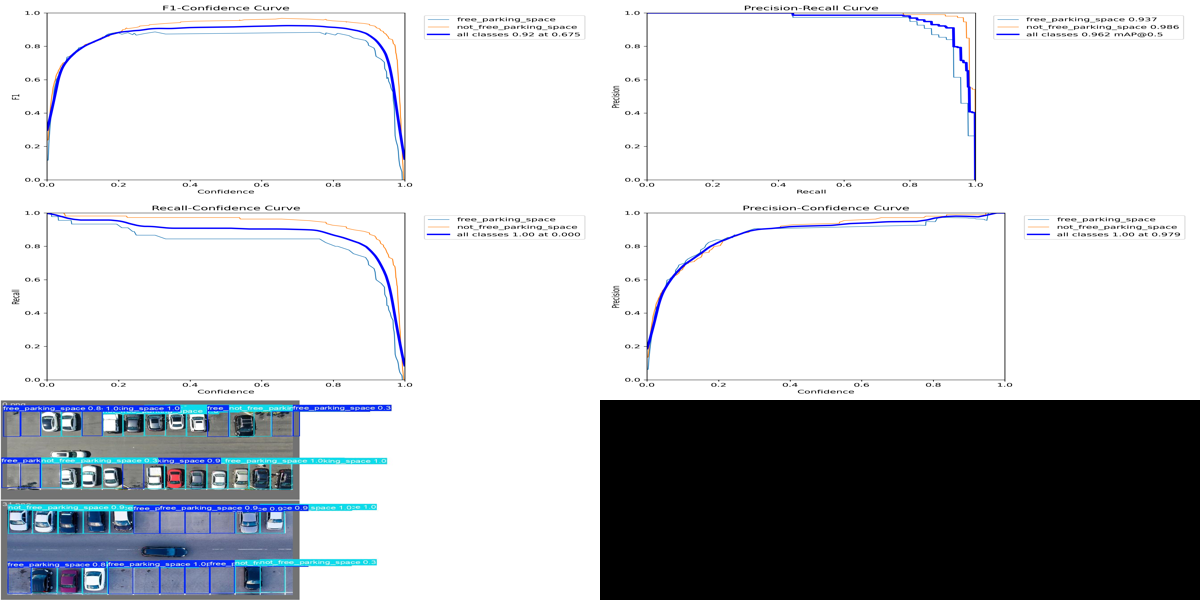

In [81]:
results = model.val() # evaluate model performance on the validation set

# List of image paths
results_paths = [
    f"{results.save_dir}/F1_curve.png",
    f"{results.save_dir}/PR_curve.png",
    f"{results.save_dir}/R_curve.png",
    f"{results.save_dir}/P_curve.png",
    f"{results.save_dir}/val_batch0_pred.jpg",
]

plot_images(results_paths)